In [45]:
#import relevant libaries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [46]:
def cam_cal(nx,ny):
    #load all relevant images for calibration
    images=glob.glob('../CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
    #Prepare  the Object- and Imagepoints
    objpts=[]
    imgpts=[]
    #initialize objp to (0,0,0),...,(9,6,0)
    objp=np.zeros((nx*ny,3),np.float32)
    objp[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    #loop through every calibration image
    for image in images:
        img=plt.imread(image)
        #convert to grayscale
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #Find and draw corners of chessboard
        ret,corners=cv2.findChessboardCorners(gray,(nx,ny),None)
        if ret==False:
            continue
        if ret==True:
            #add corners to imagepoints-list
            imgpts.append(corners)
            objpts.append(objp)
            #draw corners onto the chessboardimage
            img=cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img.shape[1:], None, None)
    return ret, mtx, dist#, rvecs, tvecs

def dist_corr(img,mtx,dist):
    undist=cv2.undistort(img,mtx,dist,None,mtx) 
    return undist

def abs_sobel_thresh(img, orient,sobel_kernel,thresh=(0,255)):
    #grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #sobel x
    sobel=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    #absolute sobel
    abs_sobel = np.absolute(sobel)
    #scaled sobel
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #binary image for sobel in x direction
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

#def col_bin(th,img):
def col_bin(th,img,img2):
    #call function for sobel in x direction
    gradientx=abs_sobel_thresh(img2,orient='x',sobel_kernel=7,thresh=(30,100))
    #create binary image for saturation
    cbinary=np.zeros_like(img)
    cbinary[(img>=th[0])&(img<=th[1])]=1
    return gradientx, cbinary

# COMBINE
def comb_binary(xgradient,colorbinary):
    #combine two binary images
    combined_binary = np.zeros_like(xgradient)
    combined_binary[(colorbinary == 1) | (xgradient == 1)] = 1
    return combined_binary

def apply_persp_transform(source,destination,combbin,img):
    M = cv2.getPerspectiveTransform(source, destination)
    warped = cv2.warpPerspective(combbin, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

def rev_persp_transform(img,source,destination):
    M = cv2.getPerspectiveTransform(destination,source)
    unwarped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return unwarped

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    weighted =  cv2.addWeighted(initial_img, α, img, β, γ)
    return weighted

def radius(ploty,leftfit_cr,rightfit_cr):
    #create variables to convert from pixels into meters
    ym_per_pixel=30/720
    xm_per_pixel=3.7/900
    y_eval=np.max(ploty)
    #calculate left and right curve radius
    left_curve_radius=((1+(2*leftfit_cr[0]*y_eval*ym_per_pixel+leftfit_cr[1])**2)**1.5)/np.absolute(2*leftfit_cr[0])
    right_curve_radius=((1+(2*rightfit_cr[0]*y_eval*ym_per_pixel+rightfit_cr[1])**2)**1.5)/np.absolute(2*rightfit_cr[0])
    #calculate mean radius
    radius=np.mean([left_curve_radius,right_curve_radius])
    #calculate the radius at the bottom and compare with middle of image to get offset
    left_curve_radius_bottom=leftfit_cr[0]*ploty**2+leftfit_cr[1]*ploty+leftfit_cr[2]
    right_curve_radius_bottom=rightfit_cr[0]*ploty**2+rightfit_cr[1]*ploty+rightfit_cr[2]
    radius_bottom=abs((left_curve_radius_bottom[719]-right_curve_radius_bottom[719])/2)
    mid=(1280/2)
    offset_car=(abs(radius_bottom-mid))*xm_per_pixel
    return radius, offset_car

def smooth(pol_left,pol_right):
    #convert pol_left and pol_right to lists
    pol_left = list(pol_left)
    pol_right = list(pol_right)
    #extract coefficients from left and right polynom
    left0=pol_left[0]
    left1=pol_left[1]
    left2=pol_left[2]
    right0=pol_right[0]
    right1=pol_right[1]
    right2=pol_right[2]
    #append coefficients to lists
    l0.append(left0)
    l1.append(left1)
    l2.append(left2)
    r0.append(right0)
    r1.append(right1)
    r2.append(right2)
    #delete first element in if there are 16 elements. This way only the last 15 frames are used to calculate aan average 
    if len(l0)==50:
        del l0[0]
        del l1[0]
        del l2[0]
        del r0[0]
        del r1[0]
        del r2[0]
    #calculate the average for each coefficient
    avg_l0=sum(l0)/len(l0)
    avg_l1=sum(l1)/len(l1)
    avg_l2=sum(l2)/len(l2)
    avg_r0=sum(r0)/len(r0)
    avg_r1=sum(r1)/len(r1)
    avg_r2=sum(r2)/len(r2)
    return avg_l0,avg_l1,avg_l2,avg_r0,avg_r1,avg_r2



In [40]:
def sliding_windows(img):
    #create histogram
    bottom_half = img[img.shape[0]//2:,:]
    histogram=np.sum(bottom_half,axis=0)
    out_img = np.dstack((img, img, img))*255
    midpoint = np.int(histogram.shape[0]//2)
    #calculate starting x coordinates at bottom of image
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #create variables (number of windows, minimum pixelnumber and margin)
    n=5
    margin=100
    minpix=40
    #calculate window height
    window_height=(img.shape[0]/n)
    #detect all non-zero pixels
    nonzero=out_img.nonzero()
    nonzerox=np.array(nonzero[1])
    nonzeroy=np.array(nonzero[0])

    #define current x position and initialize 2 empty arrays
    leftx_current=leftx_base
    rightx_current=rightx_base
    left_lane_inds=[]
    right_lane_inds=[]
    #loop through each of the n windows
    for window in range(n):
        #calculate windows height and width for left and right lane
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        win_y_low=np.int(win_y_low)
        win_y_high=np.int(win_y_high)
        
        #visualize windows
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,255), 2) 

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #use relevant pixels to create polynomials for left and right lane
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    poly_left = np.poly1d(left_fit)
    poly_right= np.poly1d(right_fit)
    
    left_lane=poly_left(ploty)
    right_lane=poly_right(ploty)
    #plt.imshow(out_img)
    #create lists which contain points that are later used to draw the area onto the image
    ptsl=[]
    ptsr=[]
    ptsl=np.column_stack((left_lane,ploty))
    ptsr=np.column_stack((right_lane,ploty))
    ptsr=np.flip(ptsr,axis=0)
    pts=np.vstack((ptsl,ptsr))
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #draw the area
    cv2.fillPoly(window_img, np.int_([pts]), (0,255, 0))    
    
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 255))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 255))
    
    #create final image
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return left_fit,right_fit,result,ploty

IMAGE

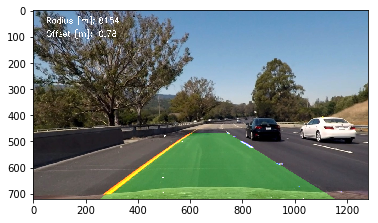

In [44]:
                    ############### MAIN CODE #############

#Variables
n_x=9
n_y=6
#import image
path='../CarND-Advanced-Lane-Lines/test_images/test6.jpg'
image1=plt.imread(path)
#camera calibration
camera_calibration=cam_cal(n_x,n_y)
ret=camera_calibration[:][0]
matrix=camera_calibration[:][1]
distort=camera_calibration[:][2]
#undistort
undistorted=dist_corr(image1,matrix,distort)

#convert to hls
HLS=cv2.cvtColor(undistorted,cv2.COLOR_BGR2HLS)
S=HLS[:,:,2]
threshold=[170,255]
#create 2 binary images
Color_binary=col_bin(threshold,S,undistorted)
cbin=Color_binary[:][0]
gradx=Color_binary[:][1]
xgrad=abs_sobel_thresh(undistorted, orient='x',sobel_kernel=5,thresh=(100,255))
#combine gradient binary and color binary
combined=comb_binary(gradx,cbin)
#combined=comb_binary(cbin)

#create source and destination points
src=np.float32([[195,720],[555,470],[730,470],[1120,720]])
dst=np.float32([[195,720],[195,0],[1120,0],[1120,720]])

#transform image to 'birds-eye' perspective
transformed=apply_persp_transform(src,dst,combined,image1)
#plt.imshow(transformed,cmap='gray')


#use the sliding_window function to find lanes in an image
lanes=sliding_windows(transformed)
#extract data for left and right lane
poly_leftlane=lanes[:][0]
poly_rightlane=lanes[:][1]
output=lanes[:][2]
ploty=lanes[:][3]
#calculate radius
radiuscurve=radius(ploty,poly_leftlane,poly_rightlane)
#convert to string
rad=str(int(radiuscurve[0]))
off=round(radiuscurve[1], 2)
offset=str(off)
#transform the image back to original
orig_persp=rev_persp_transform(output,src,dst)

#add image with lane to the original image
final = cv2.addWeighted(orig_persp, 1, undistorted, 1, 0)

#Add the radius to the upper left corner of the image
cv2.putText(final, 'Radius [m]: ',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
cv2.putText(final, 'Offset [m]: ',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
cv2.putText(final, rad,(250,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
cv2.putText(final, offset,(250,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

#show the final image
plt.imshow(final)

#safe image
#path2='../CarND-Advanced-Lane-Lines/output_images/S.jpg'
#cv2.imwrite(path2, cv2.cvtColor(final, cv2.COLOR_RGB2BGR))    
#image2=cv2.imwrite(path2,final)

VIDEO

In [5]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    poly_leftlanex = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    poly_rightlanex = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return poly_leftlanex, poly_rightlanex, ploty

def search_around(img,poly_left_lane,poly_right_lane):
    #define variables
    marginsa = 100
    #detect all nonzero pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (poly_leftlane[0]*(nonzeroy**2) + poly_leftlane[1]*nonzeroy + poly_leftlane[2] - marginsa)) & (nonzerox < (poly_leftlane[0]*(nonzeroy**2) + poly_leftlane[1]*nonzeroy + poly_leftlane[2] + marginsa)))
    right_lane_inds = ((nonzerox > (poly_rightlane[0]*(nonzeroy**2) + poly_rightlane[1]*nonzeroy + poly_rightlane[2] - marginsa)) & (nonzerox < (poly_rightlane[0]*(nonzeroy**2) + poly_rightlane[1]*nonzeroy + poly_rightlane[2] + marginsa)))

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #create 2 polynominals for left and right lane
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    poly_left = np.poly1d(left_fit)
    poly_right= np.poly1d(right_fit)

    left_lane=poly_left(ploty)
    right_lane=poly_right(ploty)
    #create 2 arrays which are used to display the lane on the image as an area
    ptsl=[]
    ptsr=[]
    ptsl=np.column_stack((left_lane,ploty))
    ptsr=np.column_stack((right_lane,ploty))
    ptsr=np.flip(ptsr,axis=0)
    pts=np.vstack((ptsl,ptsr))
    
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #create points for left and right lane to display the area around the polynomials that is used to detect pixels
    left_line_window1 = np.array([np.transpose(np.vstack([left_lane-marginsa, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_lane+marginsa,ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_lane-marginsa, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_lane+marginsa,ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    #draw the area
    cv2.fillPoly(window_img, np.int_([pts]), (0,255, 0))
    plt.imshow(window_img)

    #display area around lanes
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (255,255, 0))
    
    #create final image
    result = cv2.addWeighted(out_img,1, window_img,0.3, 1, 0)

    return left_fit,right_fit,result


In [6]:
                                    ############### MAIN CODE ##########
def process_image(image):
    #define variables
    global frameno
    global poly_l
    global poly_r
    
    n_x=9
    n_y=6

    #camera calibration
    camera_calibration=cam_cal(n_x,n_y)
    ret=camera_calibration[:][0]
    matrix=camera_calibration[:][1]
    distort=camera_calibration[:][2]
    #undistort
    undistorted=dist_corr(image,matrix,distort)
    #convert to hls
    HLS=cv2.cvtColor(undistorted,cv2.COLOR_BGR2HLS)
    S=HLS[:,:,2]
    #plt.imshow(S,cmap='gray')
    threshold=[170,200]
    #color binary
    Color_binary=col_bin(threshold,S,image)
    gradx=Color_binary[:][0]
    cbin=Color_binary[:][1]
    
    #combine binary images
    combined=comb_binary(gradx,cbin)
    plt.imshow(combined)
    
    #define source and destination points
    src=np.float32([[195,720],[555,470],[730,470],[1120,720]])
    dst=np.float32([[195,720],[195,0],[1120,0],[1120,720]])
    #transform perspective
    transformed=apply_persp_transform(src,dst,combined,image)
    
    
    #If the frame number is zero or one, or every fifth frame, use the sliding window function
    if (frameno<=1) | (frameno%25 ==0):
        lanes=sliding_windows(transformed)
        poly_leftlane=lanes[:][0]
        poly_rightlane=lanes[:][1]
        output=lanes[:][2]
        #print('poly_leftlane_sliding window: ',poly_leftlane)
        
        #use the output of the sliding window function and call the smooth function
        Poly_smooth=smooth(poly_leftlane,poly_rightlane)
        poly_l=Poly_smooth[0:3]
        poly_r=Poly_smooth[3:6]
        #print(Poly_smooth)
        #calculate the radius
        radiuscurve=radius(ploty,poly_l,poly_r)
        rad=str(int(radiuscurve[0]))
        off=round(radiuscurve[1], 2)
        offset=str(off)
        #original perspective
        unwarped=rev_persp_transform(output,src,dst)
        plt.imshow(unwarped)
        
        #add images
        final = cv2.addWeighted(unwarped, 1, undistorted, 1, 0)
        
        #print radius onto image
        cv2.putText(final, 'Radius [m]: ',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(final, 'Offset [m]: ',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(final, rad,(250,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(final, offset,(250,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        #show final image
        plt.imshow(final)
        
        #increase the frame number by one
        frameno=frameno+1
        return final

    #for every other frame, use the search around function
    if(frameno>1):
        #print(poly_l)
        #print(np.poly1d(poly_l))
        lanes2=search_around(transformed,poly_l,poly_r)
        output=lanes2[2]
        poly_leftlane=lanes2[:][0]
        poly_rightlane=lanes2[:][1]
        #print('poly_leftlane_search around: ',poly_leftlane)
        
        #call the smooth_function
        Poly_smooth=smooth(poly_leftlane,poly_rightlane)
        poly_le=Poly_smooth[0:3]
        poly_re=Poly_smooth[3:6]
        
        #calculate radius
        radiuscurve=radius(ploty,poly_le,poly_re)
        rad=str(int(radiuscurve[0]))
        off=round(radiuscurve[1], 2)
        offset=str(off)
        #original perspective
        unwarped=rev_persp_transform(output,src,dst)
        plt.imshow(unwarped)
        
        #add images together
        final = cv2.addWeighted(unwarped, 1, undistorted, 1, 0)
        
        #Add the radius to the upper left corner of the image
        cv2.putText(final, 'Radius [m]: ',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(final, 'Offset [m]: ',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(final, rad,(250,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(final, offset,(250,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        #show final image
        #plt.imshow(final)

        #increase frame number by one
        frameno=frameno+1
    
        return final





[MoviePy] >>>> Building video ../CarND-Advanced-Lane-Lines/result_project_video.mp4
[MoviePy] Writing video ../CarND-Advanced-Lane-Lines/result_project_video.mp4


100%|█████████▉| 1260/1261 [1:15:11<00:03,  3.61s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../CarND-Advanced-Lane-Lines/result_project_video.mp4 

CPU times: user 1h 11min 55s, sys: 33.8 s, total: 1h 12min 29s
Wall time: 1h 15min 14s


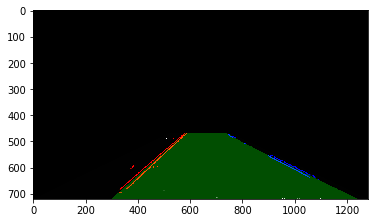

In [7]:
#create empty lists befor starting
#for each coefficient of the leftlane and rightlane polynom
l0=[]
l1=[]
l2=[]
r0=[]
r1=[]
r2=[]
poly_l=[]
poly_r=[]
#initialize the frame number 
frameno=1
video_output = '../CarND-Advanced-Lane-Lines/result_project_video.mp4'
#video_output = '../CarND-Advanced-Lane-Lines/result_harder_challenge_video.mp4'
#video_output = '../CarND-Advanced-Lane-Lines/result_challenge_video.mp4'
clip1 = VideoFileClip("../CarND-Advanced-Lane-Lines/project_video.mp4")#.subclip(20,30)
#clip1 = VideoFileClip("../CarND-Advanced-Lane-Lines/harder_challenge_video.mp4")#.subclip(0,5)
#clip1 = VideoFileClip("../CarND-Advanced-Lane-Lines/challenge_video.mp4").subclip(0,5)
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(video_output, audio=False)

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))